# Oil price forecasting with ARIMA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
import sklearn.linear_model
import sklearn.metrics
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as pylab
import scipy as sp
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#data extraction
df = pd.read_csv("./brent-daily.csv")
df.tail(1000)

,Date,Price
7353,2016-05-13,47.05
7354,2016-05-16,48.49
7355,2016-05-17,48.71
7356,2016-05-18,48.93
7357,2016-05-19,47.01
...,...,...
8348,2020-04-06,22.58
8349,2020-04-07,22.10
8350,2020-04-08,25.22
8351,2020-04-09,20.23


In [3]:
# summarising the data
df.describe()

,Price
count,8353.000000
mean,46.470559
std,32.509289
min,9.100000
25%,18.780000
50%,31.790000
75%,67.040000
max,143.950000


In [4]:
#cummulative density function
cdf = df[['Date', 'Price']]
cdf

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
8348,2020-04-06,22.58
8349,2020-04-07,22.10
8350,2020-04-08,25.22
8351,2020-04-09,20.23


<function matplotlib.pyplot.show(*args, **kw)>

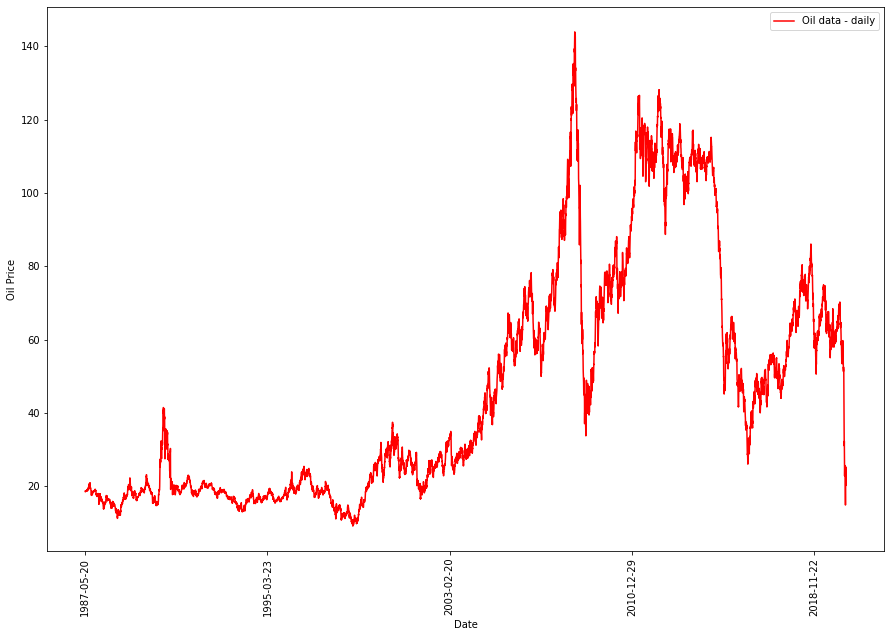

In [5]:
#data analysis
cdf.plot('Date', 'Price', color = 'red', label = 'Oil data - daily', figsize=(15, 10))
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Oil Price')
plt.legend()
plt.show

In [6]:
cdf.shape #data shape

(8353, 2)

## Implementing the augmented Dickey-Fuller test

In [40]:
from statsmodels.tsa.stattools import adfuller    
        
def test_stationarity(timeseries, printResults = True): 
        
    #determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=365).mean()
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    
    #plotting rolling statistics
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #performing augmented Dickey-Fuller test:
    significance = 0.05
    SignificanceLevel = significance
    pValue = None
    isStationary = None
   
    dftest = adfuller(timeseries, autolag='AIC')
        
    pValue = dftest[1]
        
    if (pValue < SignificanceLevel):
        isStationary = True
    else:
        isStationary = False
    if printResults:
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                                 '#Lags Used','Number of Observations Used'])
        
    # add critical values
    for key, value in dftest[4].items():
        dfoutput['Critical Value = (%s)'%key] = value
        
    print('Results of Augmented Dickey-Fuller Test:')
    print(dfoutput)  

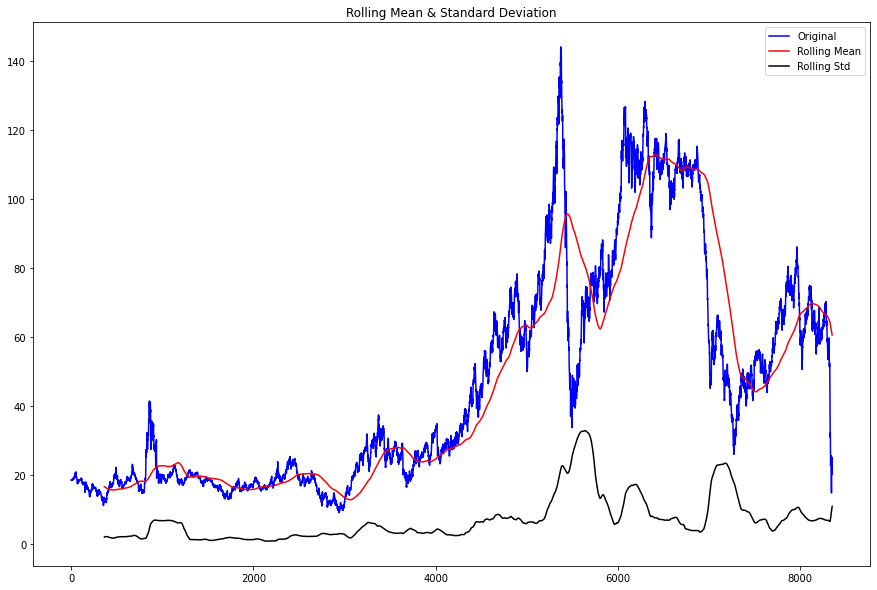

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -2.057534
p-value                           0.261929
#Lags Used                       34.000000
Number of Observations Used    8318.000000
Critical Value = (1%)            -3.431136
Critical Value = (5%)            -2.861888
Critical Value = (10%)           -2.566955
dtype: float64


In [41]:
test_stationarity(cdf['Price'])

The p-value is greater than 0.05, therefore the time series is non-stationary.

It has to be made stationary as shown by the code below.


## Making time series stationary

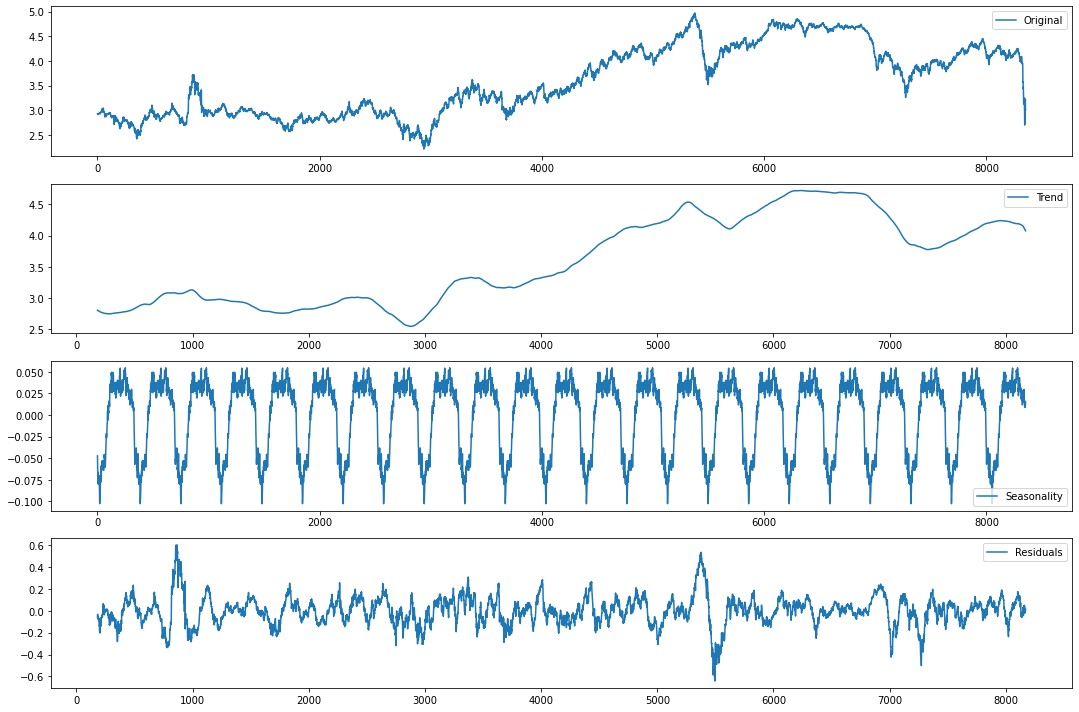

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_log = np.log(cdf['Price'])

decomposition = seasonal_decompose(ts_log, freq = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

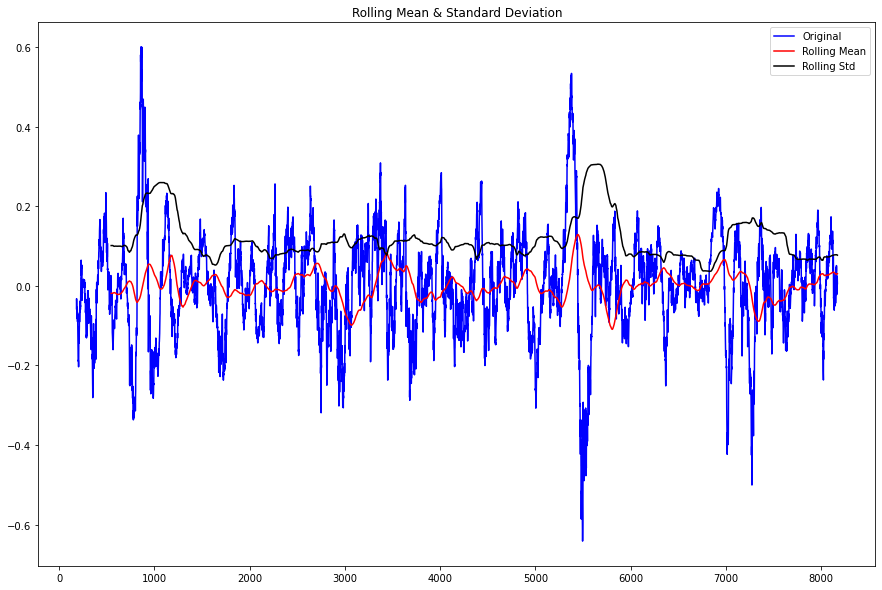

Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.663551e+00
p-value                        4.750911e-14
#Lags Used                     1.500000e+01
Number of Observations Used    7.973000e+03
Critical Value = (1%)         -3.431170e+00
Critical Value = (5%)         -2.861903e+00
Critical Value = (10%)        -2.566963e+00
dtype: float64


In [42]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

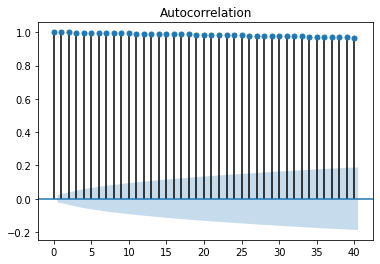

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(cdf['Price'])
plt.show()

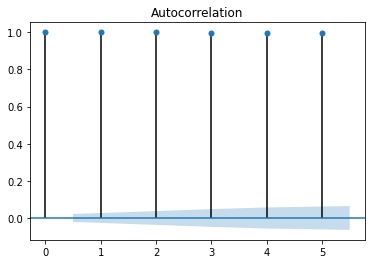

In [12]:
plot_acf(cdf['Price'], lags=5)
plt.show()

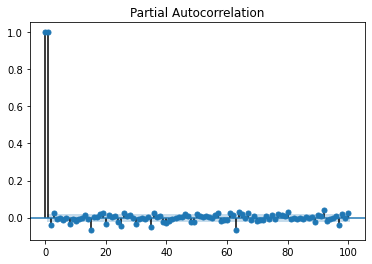

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(cdf['Price'],lags=100)
plt.show()


In [14]:
#importing the model and prediction
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(cdf.Price, order=(2, 2, 10))  
results_ARIMA = model.fit(disp=-1)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [15]:
arima_pred = results_ARIMA.predict(cdf['Price'].index[4000], cdf['Price'].index[-1], typ="levels")

In [37]:
np.array([[(arima_pred)], [(cdf.Price)]])

array([[4000    33.180201
4001    32.718195
4002    32.773355
4003    33.432148
4004    33.629945
          ...    
8348    24.411661
8349    22.294264
8350    22.114839
8351    25.455014
8352    19.912967
Length: 4353, dtype: float64],
       [0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
        ...  
8348    22.58
8349    22.10
8350    25.22
8351    20.23
8352    20.23
Name: Price, Length: 8353, dtype: float64]], dtype=object)

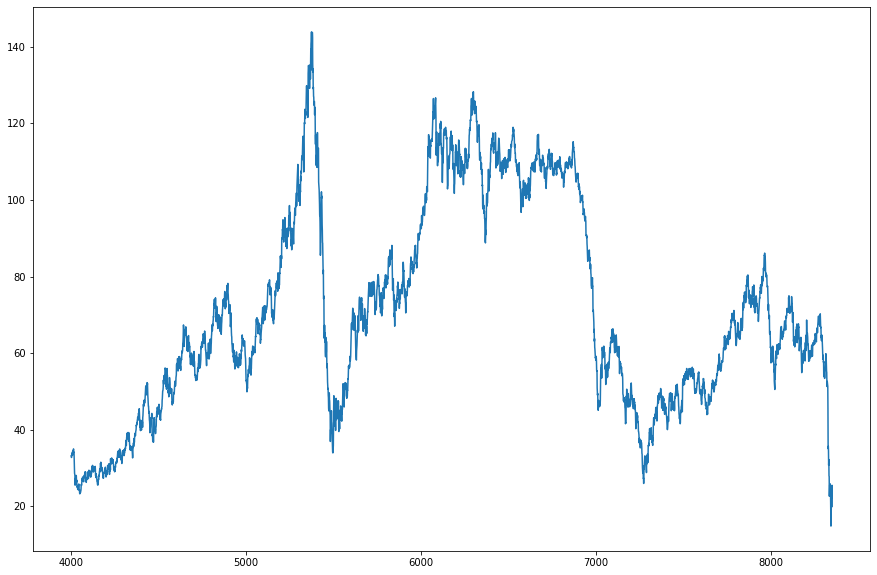

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(arima_pred)

Text(0.5, 1.0, 'Oil forecasting RMSE: 1.4253')

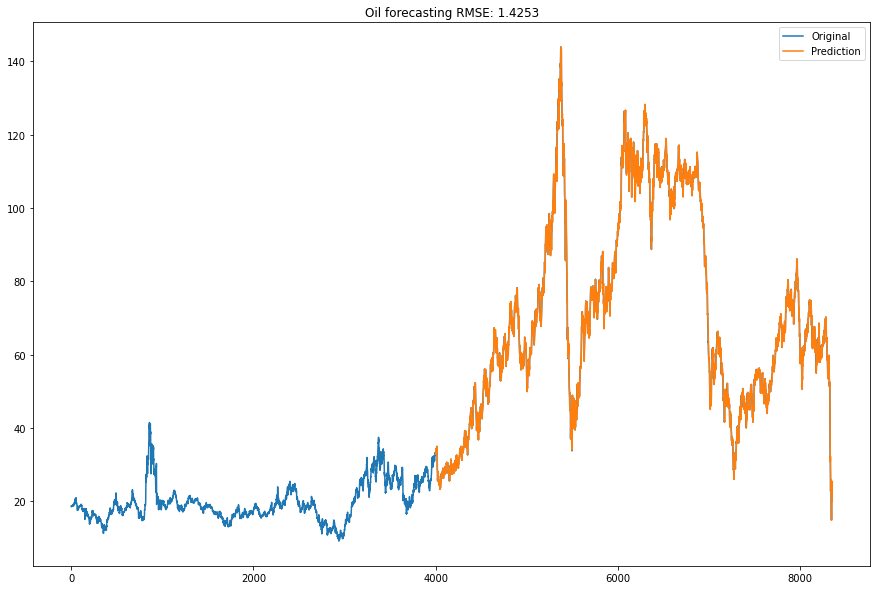

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(cdf.Price, label='Original')
plt.plot(arima_pred, label='Prediction')
plt.legend()
plt.title('Oil forecasting RMSE: %.4f'% np.sqrt(sum((arima_pred-cdf.Price[4000:])**2)/len(cdf.Price[4000:])))

In [19]:
len(cdf.Price)

8353

In [20]:
arima_pred_recent = results_ARIMA.predict(cdf['Price'].index[8300], cdf['Price'].index[-1], typ="levels")

Text(0.5, 1.0, 'RMSE: 2.6331')

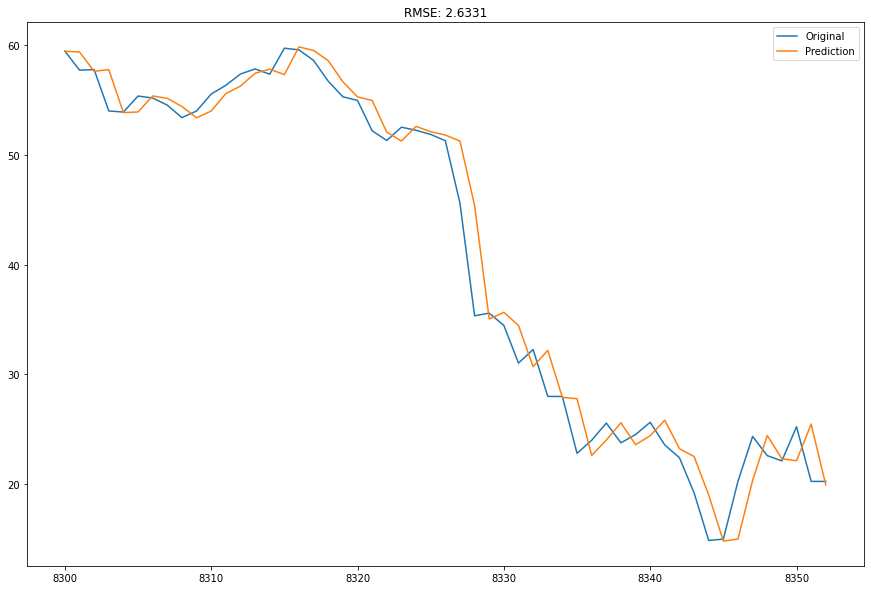

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(cdf.Price[8300:], label='Original')
plt.plot(arima_pred_recent, label='Prediction')
plt.legend(loc=1)
plt.title('RMSE: %.4f'% np.sqrt(sum((arima_pred_recent-cdf.Price[8300:])**2)/len(cdf.Price[8300:])))